#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.  
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
Постройте модель для такого предсказания.  

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.  
    Сделать тестовую выборку размером 10% от исходных данных.
5. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`.  
Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
rcParams['figure.figsize'] = 15, 5
palette = ["#202c39", "#283845", "#b8b08d", "#f2d492", "#f29559"]
rnd_data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=0).sort_index()
rnd_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
rnd_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
rnd_data.index.is_monotonic

True

Данные указаны с периодичностью 10 минут.  
Наша задача — прогноз на следующий час. Необходимо изменить интервал.

In [5]:
rnd_data = rnd_data.resample('1H').sum()
data = rnd_data.copy()
find_rolling_data = rnd_data.copy()
rnd_data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


***
### Вывод
- Загрузил данные и задал временной ряд через индекс.
- Ресемплировал данные по одному часу.<br><br>
***

## Анализ

In [6]:
rnd_data['rolling_mean'] = rnd_data.rolling(100).mean()
rnd_data['dayofweek'] = rnd_data.index.dayofweek
rnd_data['hour'] = rnd_data.index.hour

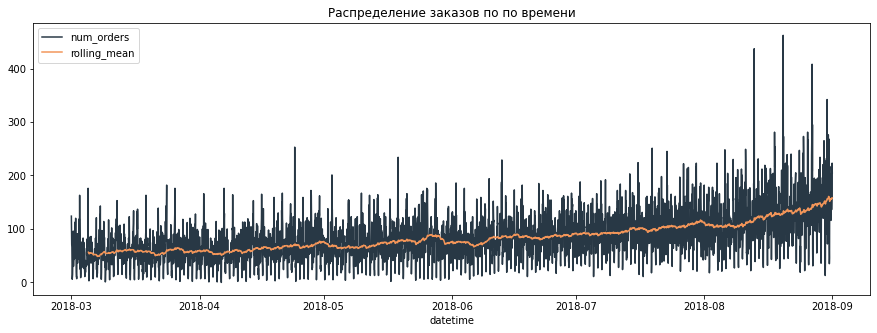

In [7]:
fig = sns.lineplot(data=rnd_data[['num_orders', 'rolling_mean']], palette=["#283845", "#f29559"], dashes=False)
plt.title('Распределение заказов по по времени')
plt.show()

In [8]:
data_pivot = pd.pivot_table(rnd_data, values='num_orders', index='dayofweek', aggfunc='mean')

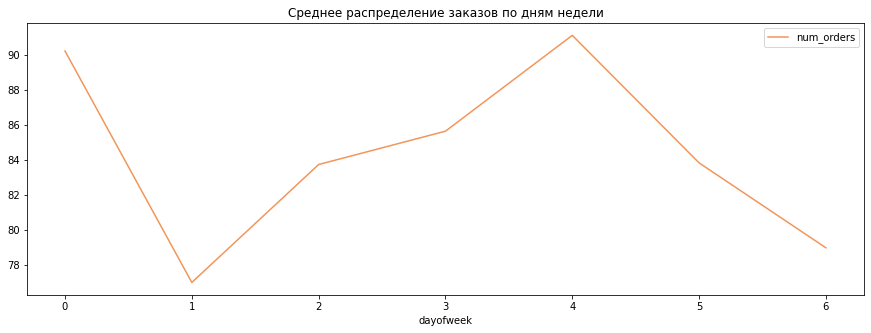

In [9]:
data_pivot.plot(c='#F29559')
plt.title('Среднее распределение заказов по дням недели')
plt.show()

### Определение ширины сдвига

In [10]:
data_pivot = pd.pivot_table(rnd_data, values='num_orders', index='hour', aggfunc='mean')

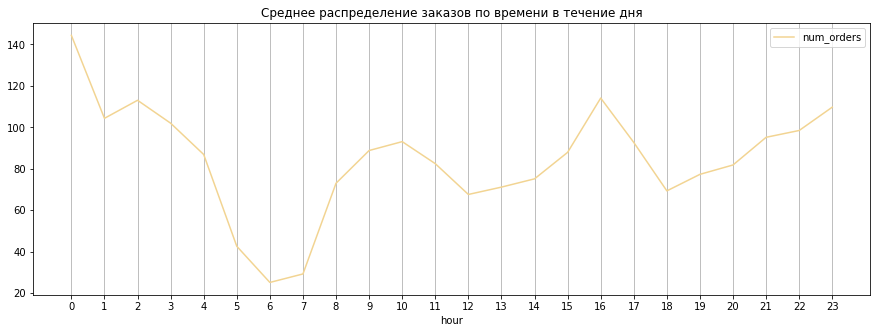

In [11]:
data_pivot.plot(c=palette[3])
plt.title('Среднее распределение заказов по времени в течение дня')
plt.xticks(range(24))
plt.grid(axis='x')
plt.show()

In [12]:
BEST_LAG = 18

In [13]:
decomposed = seasonal_decompose(rnd_data['num_orders'])

### Тренды и сезонность

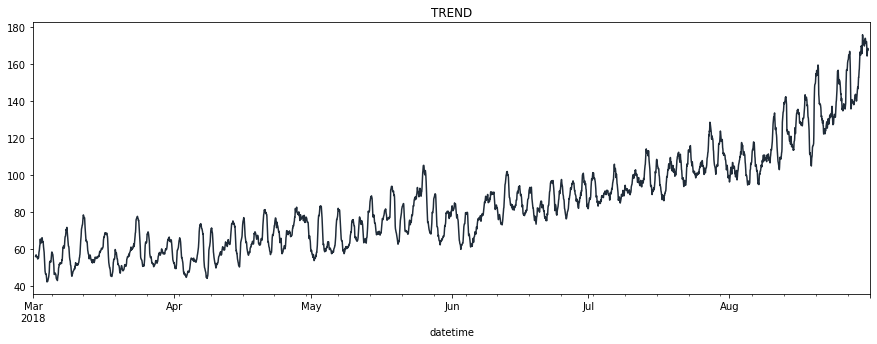

In [14]:
decomposed.trend.plot(c=palette[0])
plt.title('TREND')
plt.show()

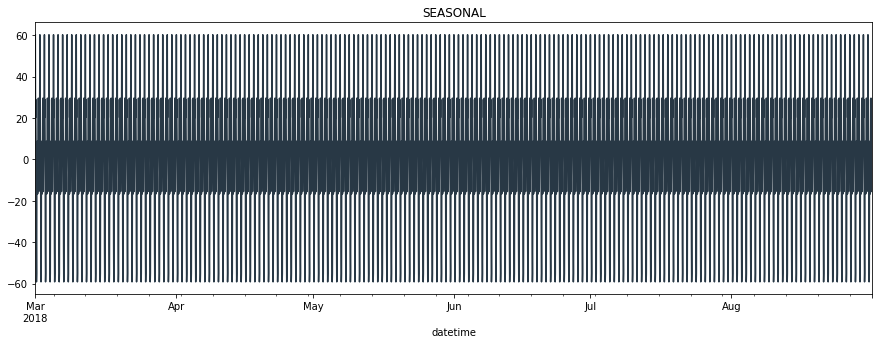

In [15]:
decomposed.seasonal.plot(c=palette[1])
plt.title('SEASONAL')
plt.show()

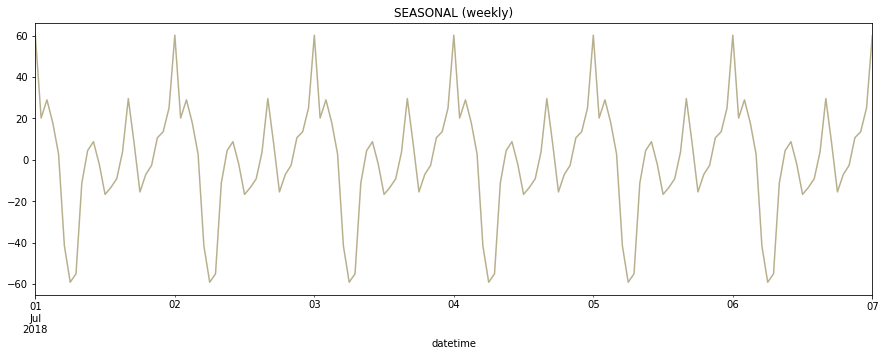

In [16]:
decomposed.seasonal.plot(c=palette[2])
plt.title('SEASONAL (weekly)')
plt.xlim(('2018-07-01', '2018-07-07'))
plt.show()

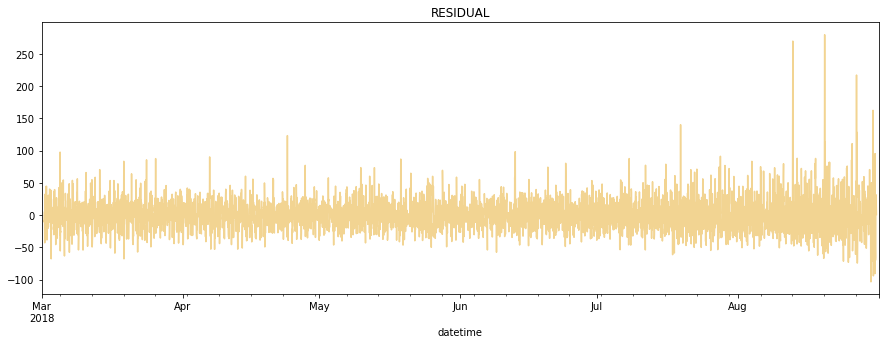

In [17]:
decomposed.resid.plot(c=palette[3])
plt.title('RESIDUAL')
plt.show()

### Определение размера скользящего окна

In [18]:
best_rmse = 1000
best_rolling_size = 0
for rolling_size in range(1, 50, 1):
    find_rolling_data['rolling_mean'] = find_rolling_data['num_orders'].shift().rolling(rolling_size).mean()
    find_rolling_data.dropna(inplace=True)
    rmse = mean_squared_error(find_rolling_data['num_orders'], find_rolling_data['rolling_mean']) ** 0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_rolling_size = rolling_size
print(
    f'RMSE: {best_rmse:.2f}\n'
    f'Размер скользящего окна: {best_rolling_size}\n'
)

RMSE: 37.50
Размер скользящего окна: 26



### Создание признаков

In [19]:
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

for lag in range(1, BEST_LAG + 1):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

data['rolling_mean'] = data['num_orders'].shift().rolling(best_rolling_size).mean()

### Подготовка выборок

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

print(
    f'Выборка разделена в пропорциях:\n'
    f'{(len(features_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(data)):.0%} — тестовая;\n'
)

Выборка разделена в пропорциях:
89% — тренировочная;
10% — тестовая;



***
### Вывод
- Виден общий тренд на увеличение заказов.
- В среднем больше всего заказов в понедельник и четверг.
- В среднем меньше всего заказов во вторник и в воскресенье.
- В среднем пиковая нагрузка приходится на полночь.
- В среднем меньше всего заказов между пятью и семью утра.
- Исходя из экстремумов количества заказов, размер сдвига возьму равным 18 часам.  
    (24:00:00 - 06:00:00)
- Определил наиболее подходящий размер скользящего окна: 26.
- Создал признаки для обучения и тестирования моделей.
- При подготовке выборок отказался от валидационной выборки,  
    потому что не получалось добиться подходящих результатов на тестовой выборке.  
    В `Slack` подсказали метод `GridSearchCV` для подбора параметров.  
    Но даже на полученных ранее параметрах получается добиться необходимых показателей `RMSE`. <br><br>
***

## Обучение

In [21]:
result = 'null'
splits = TimeSeriesSplit(n_splits=3)

### Модель `Случайный лес`

In [22]:
model = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [40],
    'max_depth': [16],
}
rf_grid = GridSearchCV(model, parameters, cv=splits, n_jobs=-1)

In [23]:
%%capture result
%%timeit
rf_grid.fit(features_train, target_train)

In [24]:
rf_fit_time = result.stdout.split(' per loop ')[0]
models_compare = {
    'RandomForestRegressor': {
        'fit_time': rf_fit_time,
    },
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time
RandomForestRegressor,3.32 s +- 560 ms


### Модель `CatBoostRegressor`

In [25]:
model = CatBoostRegressor(random_state=12345, verbose=False)
parameters = {
    'depth': [5, 8, 10],
    'learning_rate': [0.1, 0.5, 1],
}
cat_grid = model.grid_search(parameters, Pool(features_train, target_train), cv=splits, verbose=False)
best_depth = cat_grid['params']['depth']
best_learning_rate = cat_grid['params']['learning_rate']
cat_model = CatBoostRegressor(
    depth=best_depth,
    learning_rate=best_learning_rate,
    random_state=12345,
    verbose=False
)


bestTest = 32.10761258
bestIteration = 955


bestTest = 31.25498337
bestIteration = 30


bestTest = 31.64709529
bestIteration = 12


bestTest = 34.01140452
bestIteration = 536


bestTest = 35.29427258
bestIteration = 39


bestTest = 36.81309388
bestIteration = 16


bestTest = 36.60675017
bestIteration = 650


bestTest = 40.12117557
bestIteration = 109


bestTest = 42.15823765
bestIteration = 8



In [26]:
%%capture result
%%timeit
cat_model.fit(features_train, target_train)

In [27]:
cat_fit_time = result.stdout.split(' per loop ')[0]
models_compare['CatBoostRegressor'] = {
        'fit_time': cat_fit_time,
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time
RandomForestRegressor,3.32 s +- 560 ms
CatBoostRegressor,3.62 s +- 454 ms


### Модель `LGBMRegressor`

In [28]:
model = LGBMRegressor(random_state=12345)
parameters = {
    'max_depth': [5, 8, 10],
    'num_leaves': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1],
}
lgbm_grid = GridSearchCV(model, parameters, cv=splits, n_jobs=-1)

In [29]:
%%capture result
%%timeit
lgbm_grid.fit(features_train, target_train)

In [30]:
lgbm_fit_time = result.stdout.split(' per loop ')[0]
models_compare['LGBMRegressor'] = {
        'fit_time': lgbm_fit_time,
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time
RandomForestRegressor,3.32 s +- 560 ms
CatBoostRegressor,3.62 s +- 454 ms
LGBMRegressor,3.35 s +- 40.2 ms


***
### Вывод
- Обучил модели на параметрах,  
    полученных либо при разделении выборки на три группы (тренировочную, валидационную, тестовую),  
    либо методами подбора параметров. <br><br>
***

## Тестирование
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Прогноз константой

In [31]:
predictions = np.ones(test.shape[0]) * train['num_orders'].mean()

In [32]:
models_compare['Constant'] = {
        'fit_time': '-',
        'prediction_time': '-',
        'rmse': mean_squared_error(target_test, predictions) ** 0.5,
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time,prediction_time,rmse
RandomForestRegressor,3.32 s +- 560 ms,NaN,NaN
CatBoostRegressor,3.62 s +- 454 ms,NaN,NaN
LGBMRegressor,3.35 s +- 40.2 ms,NaN,NaN
Constant,-,-,84.659663


### Модель `Линейная регрессия`

In [33]:
result = 'null'
model = LinearRegression()

In [34]:
%%capture result
%%timeit
model.fit(features_train, target_train)

In [35]:
linear_fit_time = result.stdout.split(' per loop ')[0]

In [36]:
predictions = model.predict(features_test)

In [37]:
%%capture result
%%timeit
model.predict(features_test)

In [38]:
linear_prediction_time = result.stdout.split(' per loop ')[0]

In [39]:
linear_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [40]:
models_compare['LinearRegression'] = {
        'fit_time': linear_fit_time,
        'prediction_time': linear_prediction_time,
        'rmse': linear_rmse,
}
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time,prediction_time,rmse
RandomForestRegressor,3.32 s +- 560 ms,NaN,NaN
CatBoostRegressor,3.62 s +- 454 ms,NaN,NaN
LGBMRegressor,3.35 s +- 40.2 ms,NaN,NaN
Constant,-,-,84.659663
LinearRegression,4.48 ms +- 819 us,1.52 ms +- 65 us,48.729381


### Модель `Случайный лес`

In [41]:
predictions = rf_grid.best_estimator_.predict(features_test)

In [42]:
%%capture result
%%timeit
rf_grid.predict(features_test)

In [43]:
forest_prediction_time = result.stdout.split(' per loop ')[0]

In [44]:
forest_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [45]:
models_compare['RandomForestRegressor']['prediction_time'] = forest_prediction_time
models_compare['RandomForestRegressor']['rmse'] = forest_rmse
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time,prediction_time,rmse
RandomForestRegressor,3.32 s +- 560 ms,8.95 ms +- 34.9 us,45.495317
CatBoostRegressor,3.62 s +- 454 ms,NaN,NaN
LGBMRegressor,3.35 s +- 40.2 ms,NaN,NaN
Constant,-,-,84.659663
LinearRegression,4.48 ms +- 819 us,1.52 ms +- 65 us,48.729381


### Модель `CatBoostRegressor`

In [46]:
predictions = cat_model.predict(features_test)

In [47]:
%%capture result
%%timeit
cat_model.predict(features_test)

In [48]:
cat_prediction_time = result.stdout.split(' per loop ')[0]

In [49]:
cat_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [50]:
models_compare['CatBoostRegressor']['prediction_time'] = cat_prediction_time
models_compare['CatBoostRegressor']['rmse'] = cat_rmse
models_statistics = pd.DataFrame(models_compare).T
models_statistics

,fit_time,prediction_time,rmse
RandomForestRegressor,3.32 s +- 560 ms,8.95 ms +- 34.9 us,45.495317
CatBoostRegressor,3.62 s +- 454 ms,2.72 ms +- 33.2 us,44.261406
LGBMRegressor,3.35 s +- 40.2 ms,NaN,NaN
Constant,-,-,84.659663
LinearRegression,4.48 ms +- 819 us,1.52 ms +- 65 us,48.729381


### Модель `LGBMRegressor`

In [51]:
predictions = lgbm_grid.best_estimator_.predict(features_test)

In [52]:
%%capture result
%%timeit
lgbm_grid.best_estimator_.predict(features_test)

In [53]:
lgbm_prediction_time = result.stdout.split(' per loop ')[0]

In [54]:
lgbm_rmse = mean_squared_error(target_test, predictions) ** 0.5

In [55]:
models_compare['LGBMRegressor']['prediction_time'] = lgbm_prediction_time
models_compare['LGBMRegressor']['rmse'] = lgbm_rmse
models_statistics = pd.DataFrame(models_compare).T.sort_values(by='rmse')
models_statistics

,fit_time,prediction_time,rmse
LGBMRegressor,3.35 s +- 40.2 ms,2.38 ms +- 142 us,42.857062
CatBoostRegressor,3.62 s +- 454 ms,2.72 ms +- 33.2 us,44.261406
RandomForestRegressor,3.32 s +- 560 ms,8.95 ms +- 34.9 us,45.495317
LinearRegression,4.48 ms +- 819 us,1.52 ms +- 65 us,48.729381
Constant,-,-,84.659663


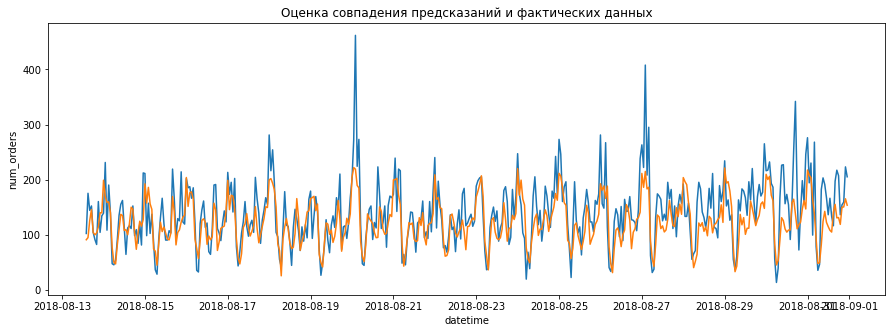

In [56]:
sns.lineplot(data=target_test, palette=["#283845"], dashes=False)
sns.lineplot(x=target_test.index, y=predictions, palette=["#f29559"], dashes=False)
plt.title('Оценка совпадения предсказаний и фактических данных')
plt.show()

***
## Общий вывод
- Модель `LGBMRegressor` прошла по условию проекта (RMSE 42.86 < 48).<br><br>
***